In [1]:
import torch
import torchvision
from torchvision import transforms
import cv2
import os
import matplotlib.pyplot as plt 
import config
import random
from models import EmbeddingFaceNet, EmbeddingMobileNetV3
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from albumentations.pytorch import ToTensorV2
import albumentations as A
from facenet_pytorch import InceptionResnetV1

In [2]:
def get_img(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
def imshow(img,text=None,should_save=False):
    npimg = torchvision.utils.make_grid(img).numpy()
    plt.axis("off")
    if text:
        plt.text(220, 243, text, fontweight='bold', horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
list_test_path = []
for id_class, name in enumerate(config.class_name):
    class_path = os.path.join(config.test_path, name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        list_test_path.append((img_path, id_class))
print('Number of test images: ', len(list_test_path))

Number of test images:  115


In [4]:
valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
plot_transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((224, 224)),
    transforms.ToTensor()])

model = EmbeddingMobileNetV3().cuda()
model.load_state_dict(torch.load(config.model_path + '/' + config.model_name), strict=False)

<All keys matched successfully>

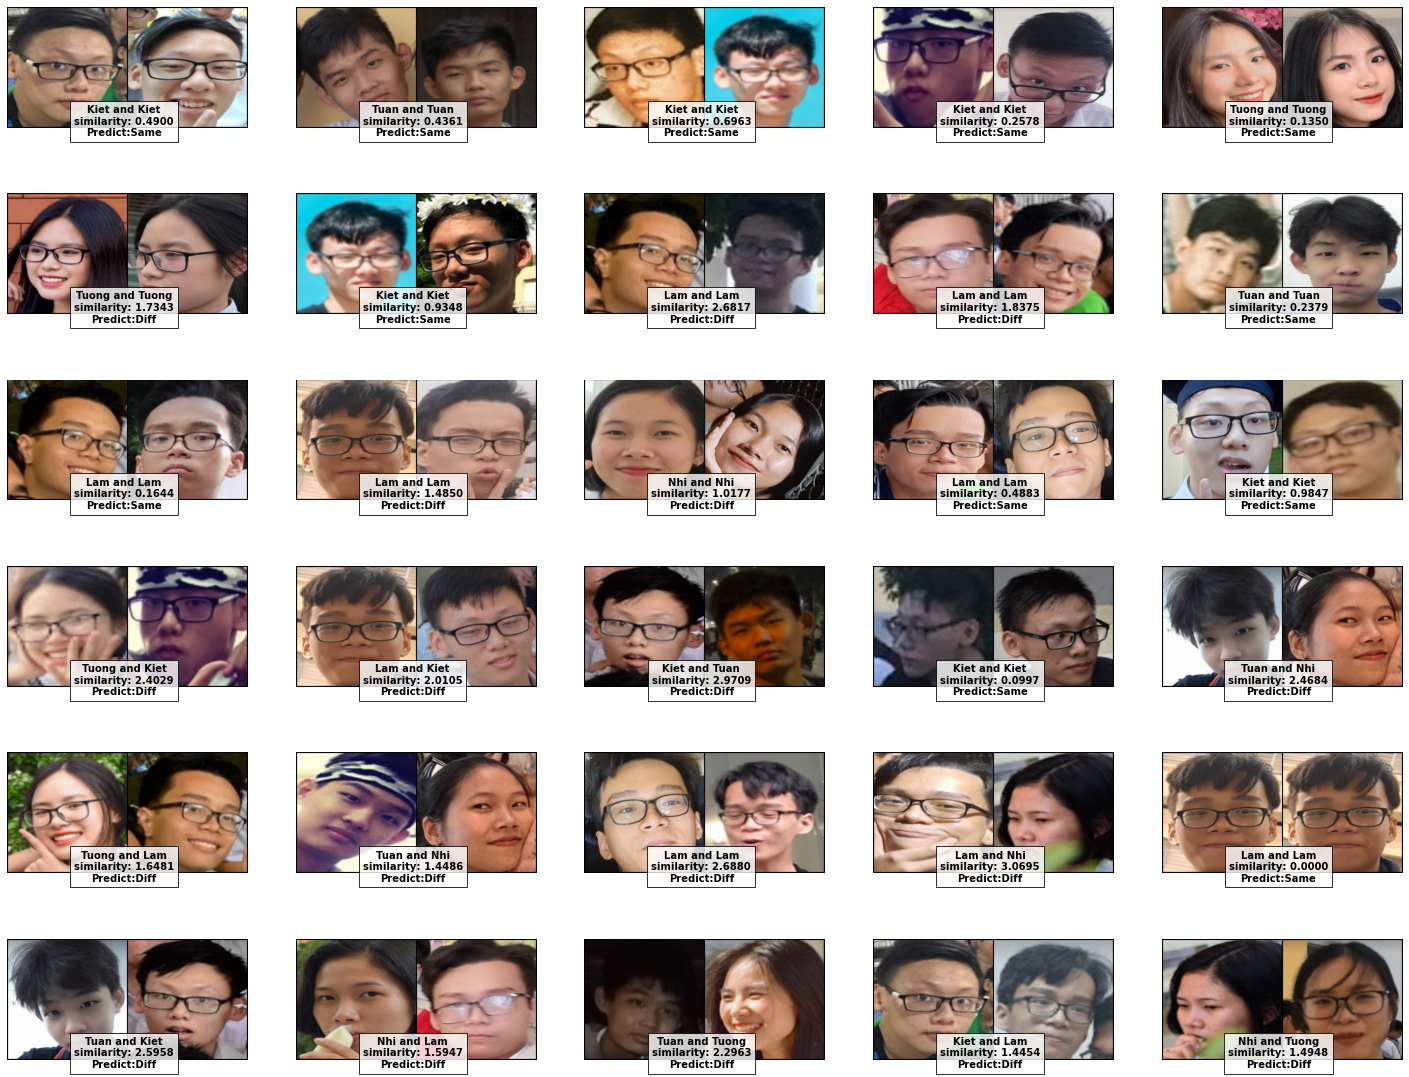

In [6]:
threshold = 1.0
plt.figure(figsize = (25, 20))
model.eval()
with torch.no_grad():
    for i in range(1, 31):
        path1, label1 = random.choice(list_test_path)
        path2, label2 = random.choice(list_test_path)
        
        if i <= 15:
            while label1 != label2:
                path1, label1 = random.choice(list_test_path)
                path2, label2 = random.choice(list_test_path)
            
        img1 = get_img(path1)
        img2 = get_img(path2)

        transform_img1 = Variable(valid_transforms(img1).float().cuda().unsqueeze(0))
        transform_img2 = Variable(valid_transforms(img2).float().cuda().unsqueeze(0))

        output1, output2 = model(transform_img1), model(transform_img2)
        dist = (output1.unsqueeze(0)-output2.unsqueeze(0)).pow(2).sum()
        img1 = plot_transforms(img1).unsqueeze(0)
        img2 = plot_transforms(img2).unsqueeze(0)

        predict_text = 'Diff'
        if dist <= threshold:
            predict_text = 'Same'

        concatenated = torch.cat((img1, img2), 0)
        text = '{} and {}\nsimilarity: {:.4f}\nPredict:{}'.format(config.class_name[label1], config.class_name[label2], dist, predict_text)
        plt.subplot(6, 5, i)
        imshow(concatenated, text)
plt.show()